In [1]:
import matplotlib.pyplot as plt
import torch
import json

In [2]:
base_path = "/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/SynthData/all/09-13-1636_epoch-369_test/"

predictions = torch.load(base_path + "predictions.pth")

In [3]:
predictions["imputation_window"]["locations"].shape

torch.Size([2000, 52, 1])

# Visualizations

In [4]:
# get 16 random samples
torch.manual_seed(12)
sample_ids = sorted(torch.randint(0, len(predictions["imputation_window"]["target"]), (16,)))
sample_ids = [v.item() for v in sample_ids]
print(sample_ids)

[83, 363, 374, 386, 720, 852, 988, 993, 1219, 1222, 1277, 1393, 1525, 1641, 1803, 1949]


In [5]:
def plot_sample(line_plot_data: dict, sample_id: int, ax):
    colors = ["red", "teal", "gold", "green", "red", "teal", "gold", "green"]
    batch_size, observed_window_count, _, _ = line_plot_data["observations"]["times"].shape

    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id]
    imputation_target = line_plot_data["imputation_window"]["target"][sample_id]
    imputation_learnt = line_plot_data["imputation_window"]["learnt"][sample_id]

    for i in range(observed_window_count):
        obs_mask = line_plot_data["observations"]["mask"][sample_id, i, ...]
        obs_times = line_plot_data["observations"]["times"][sample_id, i, ...][~obs_mask]
        obs_values = line_plot_data["observations"]["values"][sample_id, i, ...][~obs_mask]

        ax.scatter(obs_times, sample_id * 0.5 + obs_values, color=colors[i], marker="x", label=f"observed window {i}")
    ax.plot(imputation_times, sample_id * 0.5 + imputation_target, color="black", linestyle="--", label="target")
    ax.plot(imputation_times, sample_id * 0.5 + imputation_learnt, color="blue", label="learnt")
    # axs[0].legend()
    ax.set_title("{}".format(sample_id))
    ax.set_xlabel("Time")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


def plot_drift_sample(line_plot_data: dict, sample_id: int, ax):
    # plot drift
    drift = line_plot_data["drift"]["learnt"][sample_id].squeeze(-1)
    certainty = line_plot_data["drift"]["certainty"][sample_id].squeeze(-1)
    target_drift = line_plot_data["drift"]["target"][sample_id].squeeze(-1)
    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id].squeeze(-1)

    ax.plot(imputation_times, drift, color="blue", label="learnt")
    ax.fill_between(
        imputation_times.squeeze(-1),
        drift - certainty,
        drift + certainty,
        alpha=0.3,
        color="blue",
        label="certainty",
    )
    ax.plot(imputation_times, target_drift, color="black", linestyle="--", label="target")
    ax.set_title("{}".format(sample_id))

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

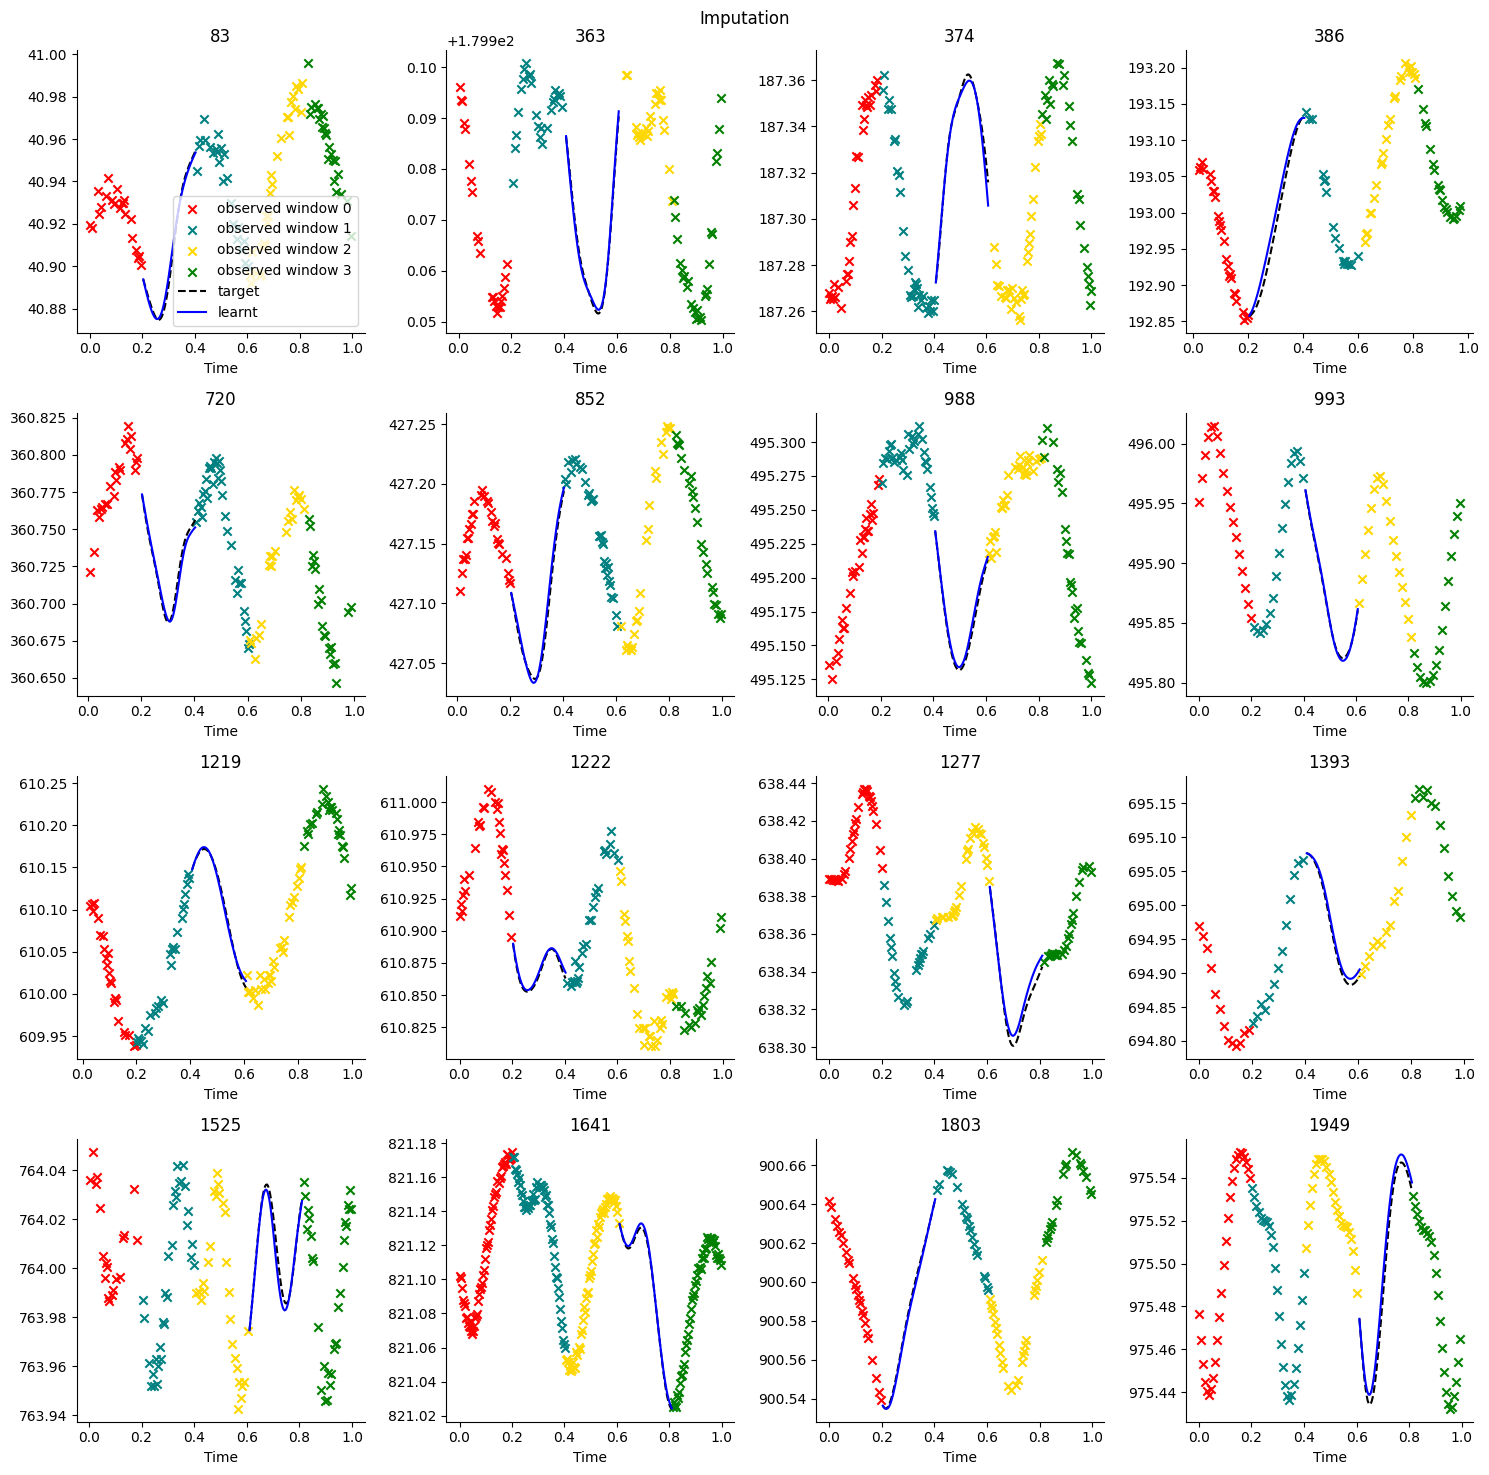

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for ax, sample_id in zip(axs.flatten(), sample_ids):
    plot_sample(predictions, sample_id, ax)
fig.suptitle("Imputation")
axs[0, 0].legend()
plt.tight_layout()
plt.savefig(base_path + "imputation.png")
plt.show()

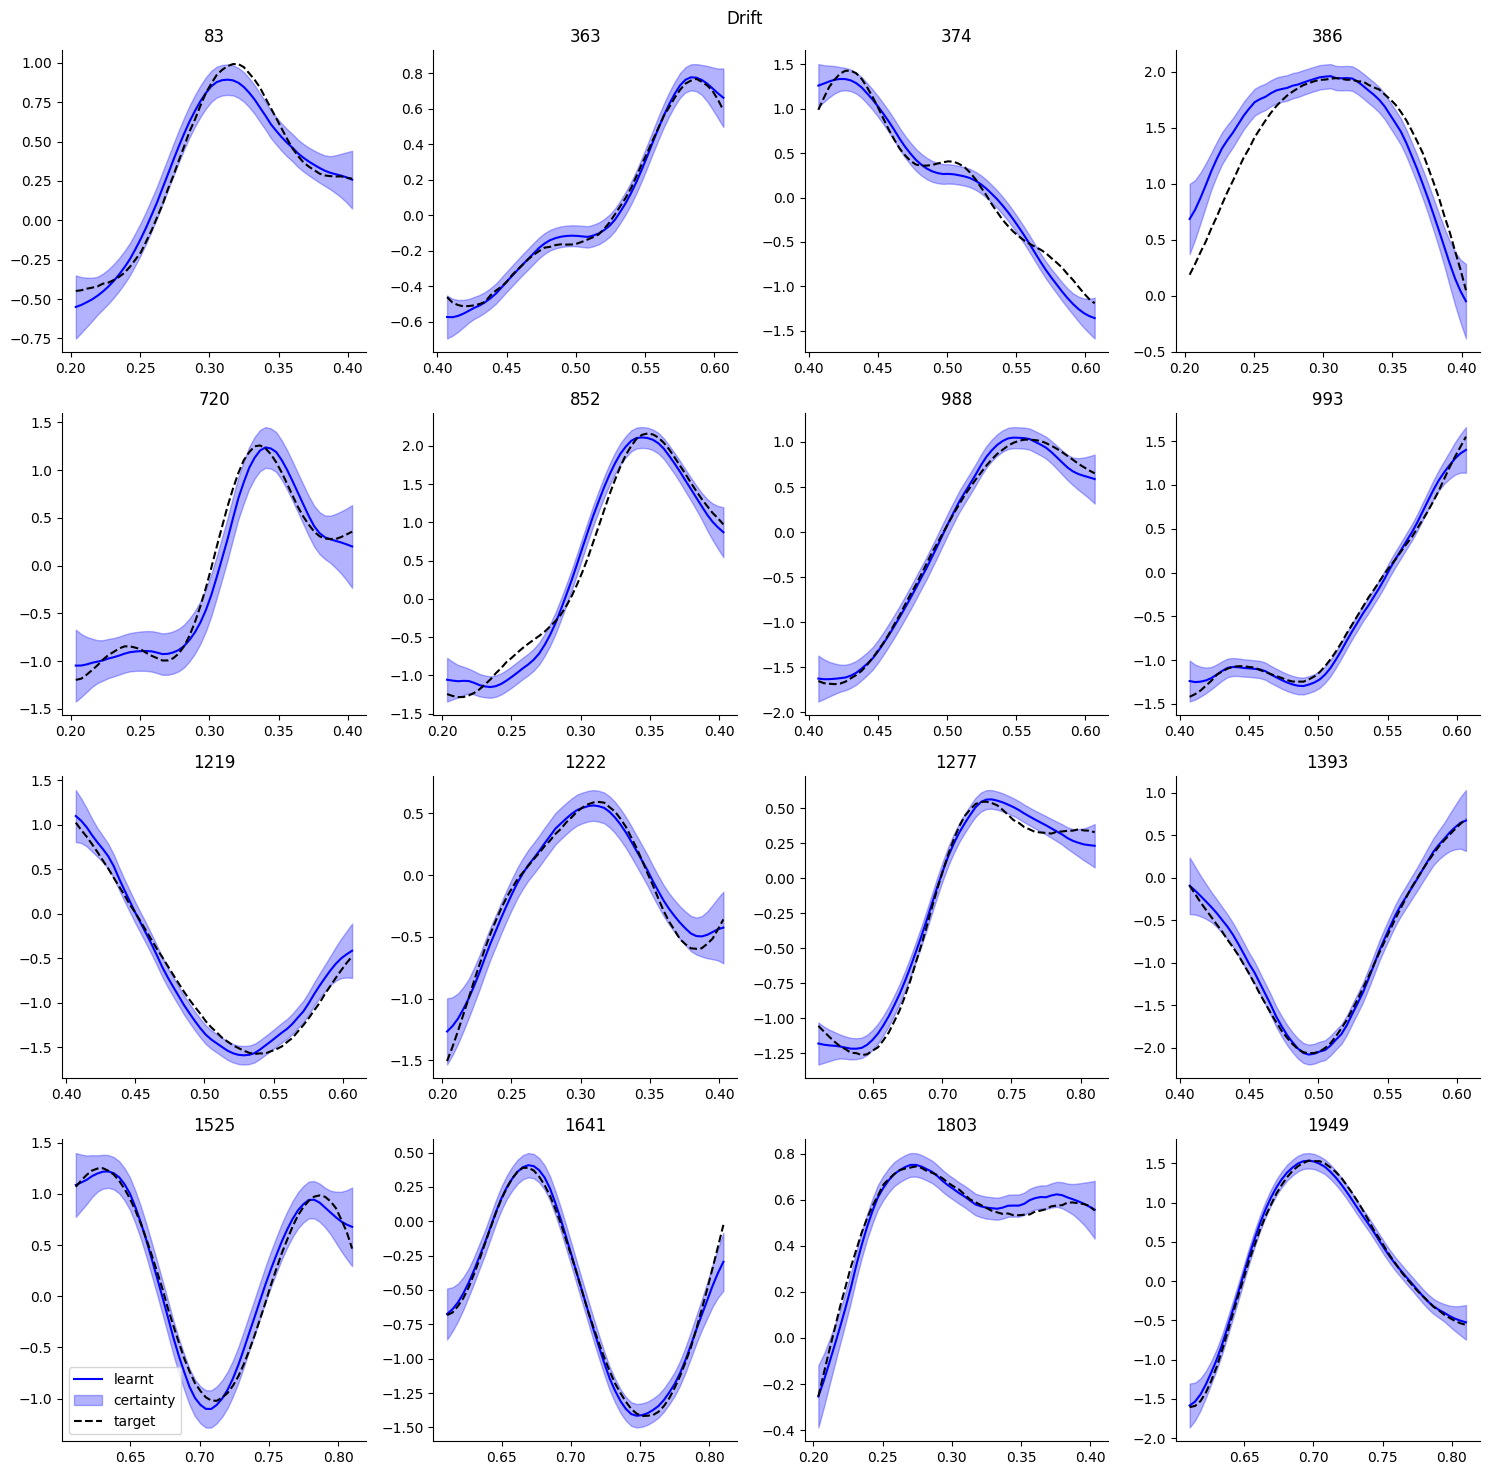

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for ax, sample_id in zip(axs.flatten(), sample_ids):
    plot_drift_sample(predictions, sample_id, ax)

fig.suptitle("Drift")
fig.tight_layout()
axs[-1][0].legend()
plt.savefig(base_path + "drift.png")
plt.show()

# Metrics

In [8]:
metrics: dict = json.load(open(base_path + "metrics.json", "r"))
print(json.dumps(metrics, indent=2))

{
  "r2_score_mean": 0.9664449691772461,
  "r2_score_std": 0.09269137680530548,
  "r2_score_above0.9": 0.9300000071525574,
  "mae_mean": 0.0028906974475830793,
  "mae_std": 0.0028542065992951393,
  "mse_mean": 2.2748492483515292e-05,
  "mse_std": 0.0001143109766417183,
  "rmse_mean": 0.003408965654671192,
  "rmse_std": 0.0033366167917847633
}


## plot single samples

In [9]:
# get sample id of worst performing prediction
performance = torch.abs(predictions["imputation_window"]["target"] - predictions["imputation_window"]["learnt"]).mean(dim=-1).mean(dim=-1)
print(performance.shape)

torch.Size([2000])


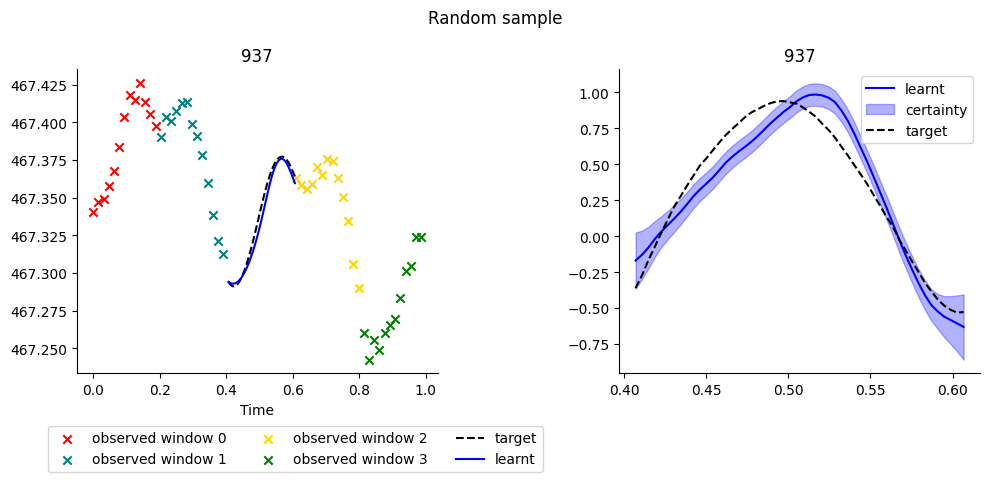

In [10]:
# random sample
sample_id = 937
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, sample_id, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))
plot_drift_sample(predictions, sample_id, axs[1])
axs[1].legend()
fig.suptitle("Random sample")
plt.tight_layout()
plt.savefig(base_path + f"sample{sample_id}.png")
plt.show()

441


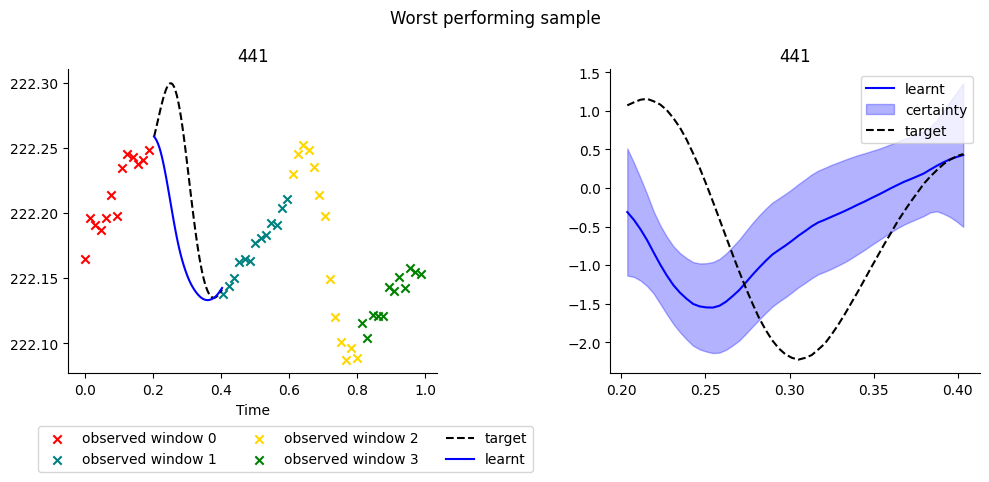

701


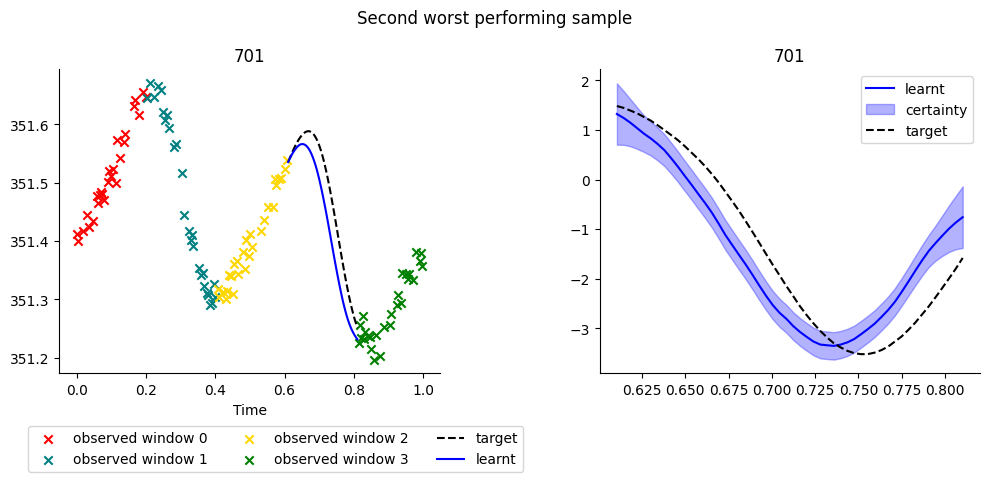

In [11]:
# worst performing sample
worst_sample_id = performance.argmax().item()
print(worst_sample_id)
# plot worst performing sample
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, worst_sample_id, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))
plot_drift_sample(predictions, worst_sample_id, axs[1])
axs[1].legend()
fig.suptitle("Worst performing sample")
plt.tight_layout()
plt.savefig(base_path + "worst_sample.png")
plt.show()

# get second worst
performance[worst_sample_id] = 0
second_worst_sample_id = performance.argmax().item()
print(second_worst_sample_id)
# plot worst performing sample
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, second_worst_sample_id, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))
plot_drift_sample(predictions, second_worst_sample_id, axs[1])
axs[1].legend()
fig.suptitle("Second worst performing sample")
plt.tight_layout()
plt.savefig(base_path + "second_worst_sample.png")
plt.show()